In [33]:
%matplotlib inline

In [34]:
import os
import time
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [35]:
START_DATE = "2013-01-01"
END_DATE = "2021-12-31"
SPLIT_FACTOR = 0.75
SPLIT_VAL_FACTOR = 0.15

# Preprocessing data

## 1. Read and visualisation data

In [36]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [37]:
raw_data = pd.read_csv(r'data\data_for_time_series\dataset_full_features.csv', header=0, sep = ",", parse_dates=[0], date_parser=parser)
mask = (raw_data['Date'] > START_DATE) & (raw_data['Date'] <= END_DATE)
stock_df = raw_data.loc[mask]
stock_df.reset_index(inplace = True, drop = True)
stock_df

,Date,Adj Close,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,2013-01-02,22.333021,1462.420044,13412.54980,3112.260010,8632.009766,14.680000,2269.127930,1.319784,86.599998,...,28.139999,28.670000,6677100.0,21.331151,21.544037,21.318135,67.941068,0.248235,28.276532,26.462801
1,2013-01-03,22.153856,1459.369995,13391.36035,3100.570068,8607.790039,14.560000,2269.127930,1.318218,87.275002,...,28.760000,28.440001,3970700.0,21.405942,21.617482,21.379339,64.147206,0.281482,28.441684,26.473316
2,2013-01-04,22.761450,1466.469971,13435.20996,3101.659912,8667.679688,13.830000,2276.991943,1.303271,87.739998,...,28.500000,29.219999,5842400.0,21.529170,21.782178,21.472445,70.220351,0.352791,28.711065,26.420268
3,2013-01-07,21.818892,1461.890015,13384.29004,3098.810059,8636.910156,13.790000,2285.364014,1.306745,88.197998,...,29.100000,28.010000,8339200.0,21.555509,21.842268,21.520295,54.731819,0.329449,28.761600,26.540400
4,2013-01-08,22.075962,1457.150024,13328.84961,3091.810059,8604.379883,13.620000,2276.070068,1.312508,87.252998,...,27.930000,28.340000,3880400.0,21.602823,21.936858,21.580387,57.486092,0.327914,28.805516,26.614484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,4791.189941,36302.37891,15871.259770,17141.089840,17.680000,3615.969971,1.132426,114.333000,...,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,58.105626,0.302337,66.388560,62.033441
2263,2021-12-28,66.930000,4786.350098,36398.21094,15781.719730,17134.160160,17.540001,3630.112061,1.133003,114.792000,...,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,61.772180,0.438992,66.711888,61.891113
2264,2021-12-29,67.010002,4793.060059,36488.62891,15766.219730,17149.929690,16.950001,3597.000000,1.131478,114.773003,...,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,62.104439,0.547438,67.116617,61.917051
2265,2021-12-30,66.860001,4778.729980,36398.07813,15741.559570,17164.240230,17.330000,3619.189941,1.136015,114.947998,...,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,61.033303,0.614197,67.396706,62.084962


In [38]:
stock_df[stock_df.isna().any(axis=1)]

,Date,Adj Close,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold


In [39]:
num_training_days = int(stock_df.shape[0]*SPLIT_FACTOR)
split_point = stock_df[num_training_days: num_training_days+1].values[0][0]
year = split_point.year
month = split_point.month
day = split_point.day
print(f"Number of training days: {num_training_days}. Number of test days: {stock_df.shape[0]-num_training_days}.")
print(f"Split date is: {split_point}. Index is: {stock_df[num_training_days: num_training_days+1].index.values[0]}")

Number of training days: 1700. Number of test days: 567.
Split date is: 2019-10-03 00:00:00. Index is: 1700


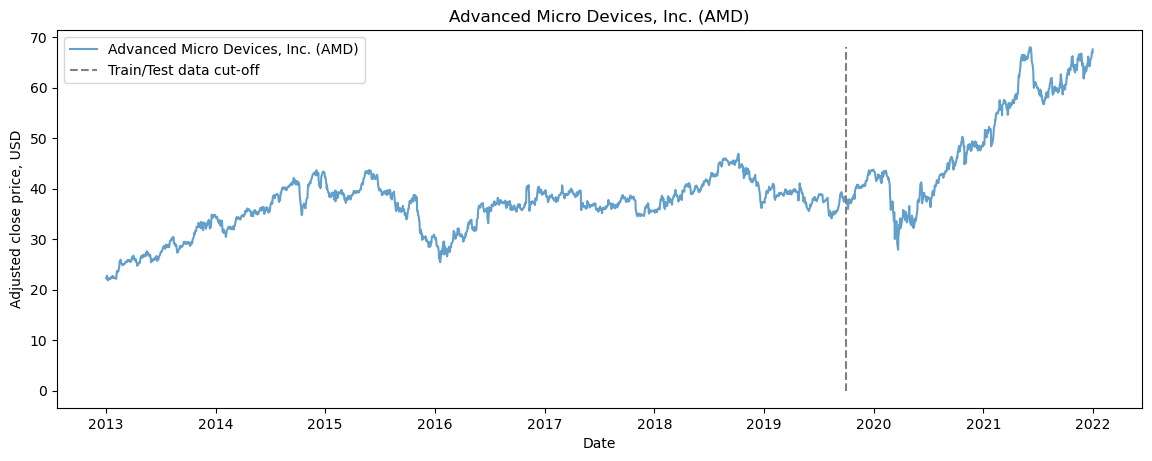

In [40]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(stock_df['Date'], stock_df['Adj Close'], label='Advanced Micro Devices, Inc. (AMD)', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, stock_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.show()

## 2. Split data

In [41]:
target = np.array(stock_df["Adj Close"])
features =  stock_df.iloc[:, 1:] 
features_s = features
features_s.shape, target.shape
# Махаме колоната "Date" и оставяме "Adj Close" във features

((2267, 99), (2267,))

In [42]:
num_train_samples = int((SPLIT_FACTOR-SPLIT_VAL_FACTOR) * len(features_s))
num_val_samples = int(SPLIT_VAL_FACTOR * len(features_s))
num_test_samples = len(features_s) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1360
num_val_samples: 340
num_test_samples: 567


## 3.Normalize data

In [43]:
def min_max_normalize(features, target):
    features_n = (features - target.min ()) / (target.max () - target.min ())
    return features_n

In [44]:
def min_max_normalize_inverse_transform(features_n, target):
    features_i = features_n * (target.max () - target.min ())+ target.min ()
    return features_i

In [45]:
def standart_scaler(aray):
    mean = aray.mean()
    std = aray.std()
    return (aray - mean) / std

In [46]:
features = min_max_normalize(features_s, target)

In [47]:
features.min(), features.max()

(Adj Close      0.000000
 ^GSPC         31.089753
 ^DJI         288.234745
 ^IXIC         66.497037
 ^NYA         185.901147
                 ...    
 ma_21         -0.010847
 rsi           -0.091111
 macd          -0.533847
 bolu           0.139875
 bold           0.099667
 Length: 99, dtype: float64,
 Adj Close      1.000000
 ^GSPC        103.346683
 ^DJI         789.883326
 ^IXIC        347.336936
 ^NYA         374.478838
                 ...    
 ma_21          0.967675
 rsi            1.349619
 macd          -0.421132
 bolu           1.066798
 bold           0.953938
 Length: 99, dtype: float64)

In [18]:
# mean = features[:num_train_samples].mean(axis=0)
# features = features - mean
# std = features[:num_train_samples].std(axis=0)
# features = features/std
# mean, std

## 4. Prepare time series

In [149]:
sampling_rate = 1 
sequence_length = 30 
delay = sampling_rate * (sequence_length + 1) # 31st day predict
batch_size = 64
  
train_dataset = timeseries_dataset_from_array(
    features[:-delay],
    targets=target[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = timeseries_dataset_from_array(
    features[:-delay],
    targets=target[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = timeseries_dataset_from_array(
    features[:-delay],
    targets=target[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [151]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (64, 30, 99)
targets shape: (64,)


In [152]:
test_dataset, val_dataset, train_dataset,

(<BatchDataset shapes: ((None, None, 99), (None,)), types: (tf.float64, tf.float64)>,
 <BatchDataset shapes: ((None, None, 99), (None,)), types: (tf.float64, tf.float64)>,
 <BatchDataset shapes: ((None, None, 99), (None,)), types: (tf.float64, tf.float64)>)

In [153]:
train_dataset

<BatchDataset shapes: ((None, None, 99), (None,)), types: (tf.float64, tf.float64)>

In [154]:
dataset1 = tf.data.Dataset.zip((train_dataset, test_dataset, val_dataset))
# dataset1.element_spec
# dataset1.element_spec.value_type

dataset1

<ZipDataset shapes: (((None, None, 99), (None,)), ((None, None, 99), (None,)), ((None, None, 99), (None,))), types: ((tf.float64, tf.float64), (tf.float64, tf.float64), (tf.float64, tf.float64))>

In [155]:
counter = 0
for a, (b) in train_dataset:
    counter +=1
    print('shapes: {a.shape}, {b.shape}'.format(a=a, b=b, c=c))
print(counter)

shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (64, 30, 99), (64,)
shapes: (51, 30, 99), (51,)
21


In [156]:
features.shape, target.shape

((2267, 99), (2267,))

In [157]:
len(test_dataset), len(val_dataset),  len(train_dataset)

(8, 5, 21)

# Models
## 1. Linear regression

In [196]:
tf.keras.backend.clear_session()

In [197]:
inputs = Input(shape=(sequence_length, features.shape[-1]))
x = Flatten()(inputs)
# x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
  
callbacks = [
    ModelCheckpoint("stock_predictor_linear_regression.keras",  
                                    save_best_only=True)
] 
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = load_model("stock_predictor_linear_regression.keras")      
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
21/21 [==============================] - 0s 12ms/step - loss: 26672416.0000 - mae: 3957.4421 - val_loss: 20073630.0000 - val_mae: 3625.9136
Epoch 2/100
21/21 [==============================] - 0s 6ms/step - loss: 12703683.0000 - mae: 2753.7227 - val_loss: 13404426.0000 - val_mae: 3001.3135
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 9323341.0000 - mae: 2369.5439 - val_loss: 9904052.0000 - val_mae: 2572.6624
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 6967608.5000 - mae: 2035.0286 - val_loss: 7264660.0000 - val_mae: 2186.7290
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 5231143.0000 - mae: 1758.9752 - val_loss: 5334492.0000 - val_mae: 1866.9531
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 4140101.2500 - mae: 1556.31 - 0s 6ms/step - loss: 3954515.2500 - mae: 1517.8198 - val_loss: 3995560.7500 - val_mae: 1609.2054
Epoch 7/100
21/21 [==============================] - 0s

In [198]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 99)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 2970)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2971      
Total params: 2,971
Trainable params: 2,971
Non-trainable params: 0
_________________________________________________________________


In [199]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()



,loss,mae,val_loss,val_mae,epoch
0,26672416.0,3957.442139,20073630.0,3625.913574,0
1,12703683.0,2753.722656,13404426.0,3001.313477,1
2,9323341.0,2369.543945,9904052.0,2572.662354,2
3,6967608.5,2035.028564,7264660.0,2186.729004,3
4,5231143.0,1758.975220,5334492.0,1866.953125,4


In [200]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


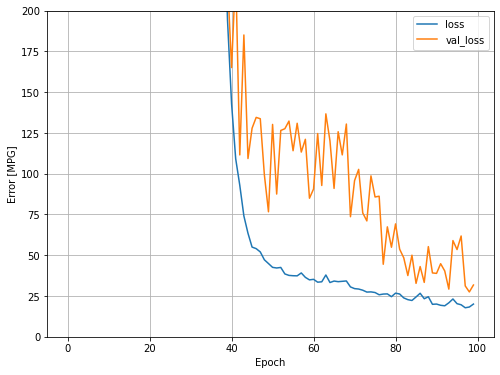

In [201]:
plot_loss(history)

In [202]:
val_loss = pd.DataFrame(history.history["val_loss"])
val_loss

,0
0,2.007363e+07
1,1.340443e+07
2,9.904052e+06
3,7.264660e+06
4,5.334492e+06
...,...
95,5.349453e+01
96,6.181834e+01
97,3.119788e+01
98,2.750813e+01


In [208]:
predicted_stock_price = model.predict(test_dataset)  
predicted_stock_price[:, -1]
predicted_stock_price.mean()
# samples[:, -1:1]

63.99131

In [209]:
train_data = stock_df["Adj Close"][0:num_train_samples]
val_data = stock_df["Adj Close"][num_train_samples:num_val_samples+num_train_samples]
test_data = stock_df["Adj Close"][num_val_samples+num_train_samples:]
all_data = stock_df["Adj Close"]

In [210]:
predicted_stock_price[1]

array([75.083206], dtype=float32)

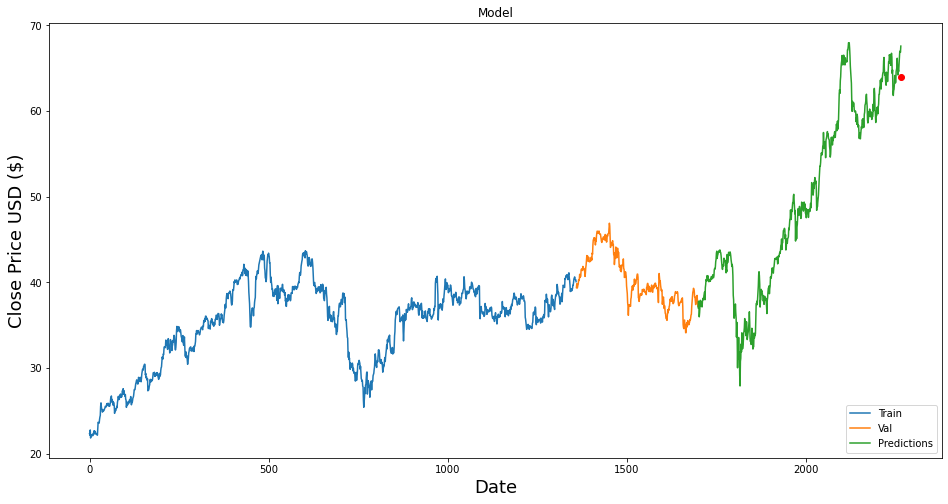

In [211]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data)
plt.plot(val_data)
plt.plot(test_data)
plt.plot(len(test_data)+len(val_data)+len(train_data),predicted_stock_price.mean(),'ro')
# plt.plot(predicted_stock_price[:, -1],'ro')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## 2. LSTM 

In [232]:
tf.keras.backend.clear_session()

In [233]:
inputs = Input(shape=(sequence_length, features.shape[-1]))
x = LSTM(16, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = Dropout(0.25)(x)
x = LSTM(32, recurrent_dropout=0.25,return_sequences=True)(x)
x = Dropout(0.25)(x)
x = LSTM(16, recurrent_dropout=0.25, return_sequences=False)(x)
x = Dropout(0.25)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
  
callbacks = [
    ModelCheckpoint("stock_predictor_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = load_model("stock_predictor_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
21/21 [==============================] - 1s 38ms/step - loss: 1312.8348 - mae: 35.9499 - val_loss: 1656.8129 - val_mae: 40.5814
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 1302.9127 - mae: 35.8120 - val_loss: 1646.4585 - val_mae: 40.4536
Epoch 3/50
21/21 [==============================] - 0s 23ms/step - loss: 1293.9886 - mae: 35.6868 - val_loss: 1636.3696 - val_mae: 40.3287
Epoch 4/50
21/21 [==============================] - 1s 24ms/step - loss: 1285.1149 - mae: 35.5627 - val_loss: 1626.2969 - val_mae: 40.2036
Epoch 5/50
21/21 [==============================] - 0s 23ms/step - loss: 1276.1414 - mae: 35.4362 - val_loss: 1616.2928 - val_mae: 40.0790
Epoch 6/50
21/21 [==============================] - 0s 23ms/step - loss: 1267.2666 - mae: 35.3107 - val_loss: 1606.3265 - val_mae: 39.9545
Epoch 7/50
21/21 [==============================] - 0s 23ms/step - loss: 1258.3937 - mae: 35.1845 - val_loss: 1596.3549 - val_mae: 39.8295
Epoch 8/50
21/21 [=========

In [234]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 99)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 16)            7424      
_________________________________________________________________
dropout (Dropout)            (None, 30, 16)            0         
_________________________________________________________________
dense (Dense)                (None, 30, 1)             17        
Total params: 7,441
Trainable params: 7,441
Non-trainable params: 0
_________________________________________________________________


In [235]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
45,940.936218,30.320532,1232.439697,34.963432,45
46,934.067688,30.206461,1223.724854,34.838554,46
47,926.380615,30.077145,1215.050781,34.713814,47
48,918.549011,29.944164,1206.399780,34.588959,48
49,911.129028,29.819590,1197.779785,34.464108,49


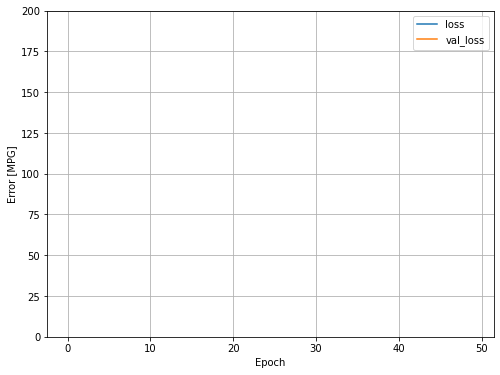

In [236]:
plot_loss(history)

In [76]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [223]:
loss = pd.DataFrame(history.history["loss"])
loss

,0
0,1184.999512
1,1081.537964
2,1035.366211
3,998.884094
4,970.165405
5,943.662476
6,924.130249
7,901.535583
8,878.512756
9,856.763062


In [237]:
predicted_stock_price = model.predict(test_dataset)  
predicted_stock_price

array([[[4.6160545],
        [5.5619736],
        [5.706955 ],
        ...,
        [5.730063 ],
        [5.730063 ],
        [5.730063 ]],

       [[4.6160545],
        [5.5619736],
        [5.706955 ],
        ...,
        [5.730063 ],
        [5.730063 ],
        [5.730063 ]],

       [[4.6160545],
        [5.5619736],
        [5.706955 ],
        ...,
        [5.730063 ],
        [5.730063 ],
        [5.730063 ]],

       ...,

       [[4.6160545],
        [5.5619736],
        [5.706955 ],
        ...,
        [5.730063 ],
        [5.730063 ],
        [5.730063 ]],

       [[4.6160545],
        [3.898963 ],
        [5.325064 ],
        ...,
        [5.730063 ],
        [5.730063 ],
        [5.730063 ]],

       [[4.6160545],
        [5.5619736],
        [5.706955 ],
        ...,
        [5.730063 ],
        [5.730063 ],
        [5.730063 ]]], dtype=float32)

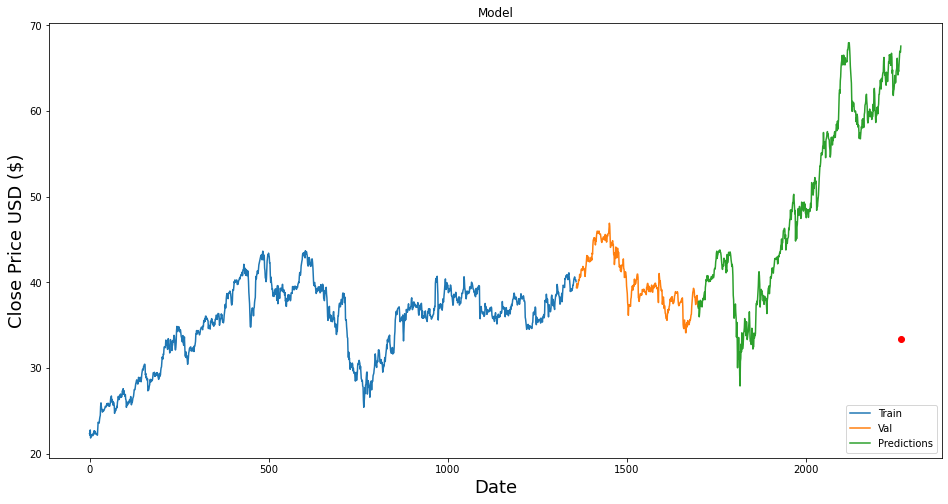

In [83]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data)
plt.plot(val_data)
plt.plot(test_data)

plt.plot(len(test_data)+len(val_data)+len(train_data),predicted_stock_price[1],'ro')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## 3. GPU

In [198]:
tf.keras.backend.clear_session()

In [145]:
inputs = Input(shape=(sequence_length, features.shape[-1]))
x = GRU(64, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = GRU(32, recurrent_dropout=0.25, return_sequences=True)(x)
x = Dropout(0.25)(x)
x = GRU(16, recurrent_dropout=0.25)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)


callbacks = [
    ModelCheckpoint("stock_predictor_gpu.keras",
                                    save_best_only=True)
]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=[callbacks, es])
model = load_model("stock_predictor_gpu.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
84/84 [==============================] - 5s 57ms/step - loss: 964.6675 - mae: 30.7055 - val_loss: 1137.5457 - val_mae: 33.5497
Epoch 2/50
84/84 [==============================] - 4s 46ms/step - loss: 846.9043 - mae: 28.7489 - val_loss: 1043.1707 - val_mae: 32.1124
Epoch 3/50
84/84 [==============================] - 4s 45ms/step - loss: 766.7805 - mae: 27.3202 - val_loss: 954.0921 - val_mae: 30.6941
Epoch 4/50
84/84 [==============================] - 4s 45ms/step - loss: 691.3146 - mae: 25.9016 - val_loss: 869.1026 - val_mae: 29.2770
Epoch 5/50
84/84 [==============================] - 4s 46ms/step - loss: 619.8189 - mae: 24.4837 - val_loss: 788.0236 - val_mae: 27.8579
Epoch 6/50
84/84 [==============================] - 4s 47ms/step - loss: 552.5043 - mae: 23.0660 - val_loss: 711.2262 - val_mae: 26.4436
Epoch 7/50
84/84 [==============================] - 4s 49ms/step - loss: 489.1518 - mae: 21.6495 - val_loss: 638.3514 - val_mae: 25.0278
Epoch 8/50
84/84 [=====================

In [146]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 99)]          0         
_________________________________________________________________
gru (GRU)                    (None, 30, 64)            31680     
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 32)            9408      
_________________________________________________________________
dropout (Dropout)            (None, 30, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 43,505
Trainable params: 43,505
Non-trainable params: 0
__________________________________________________

In [147]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mae,val_loss,val_mae,epoch
40,20.228369,3.628119,28.910234,4.573720,40
41,20.231689,3.622801,28.949770,4.577320,41
42,20.229235,3.625744,28.664288,4.551247,42
43,20.228897,3.625830,28.914858,4.574140,43
44,20.231625,3.627546,28.810495,4.564616,44
45,20.232889,3.623182,28.544794,4.540311,45
46,20.234329,3.620443,28.732796,4.557505,46
47,20.230803,3.620841,28.604910,4.545818,47
48,20.226030,3.622016,28.977581,4.579861,48
49,20.234751,3.625744,28.361101,4.523422,49


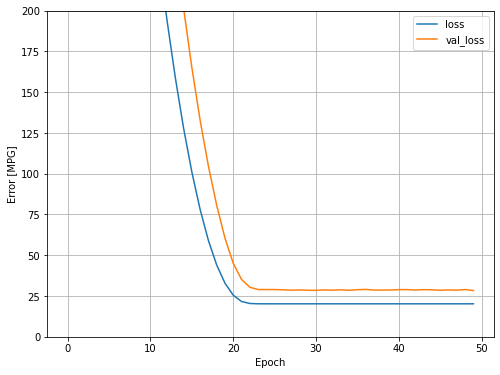

In [148]:
plot_loss(history)

In [149]:
predicted_stock_price = model.predict(test_dataset)  
predicted_stock_price

array([[35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.49062],
       [35.4

## 4. Bidirectional RNNs

In [150]:
tf.keras.backend.clear_session()

In [151]:
inputs = Input(shape=(sequence_length, features.shape[-1]))
x = Bidirectional(LSTM(64))(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs) 

callbacks = [
    ModelCheckpoint("stock_predictor_bidirectional.keras",
                                    save_best_only=True)
    ]
    
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                   callbacks=callbacks)

model = load_model("stock_predictor_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
84/84 [==============================] - 2s 29ms/step - loss: 360.5073 - mae: 17.6696 - val_loss: 239.3012 - val_mae: 15.0778
Epoch 2/50
84/84 [==============================] - 2s 21ms/step - loss: 67.2041 - mae: 7.1601 - val_loss: 50.4001 - val_mae: 6.3197
Epoch 3/50
84/84 [==============================] - 2s 21ms/step - loss: 20.7917 - mae: 3.7530 - val_loss: 27.3392 - val_mae: 4.4287
Epoch 4/50
84/84 [==============================] - 2s 20ms/step - loss: 21.0768 - mae: 3.6927 - val_loss: 28.3910 - val_mae: 4.5262
Epoch 5/50
84/84 [==============================] - 2s 20ms/step - loss: 20.3653 - mae: 3.6281 - val_loss: 30.4737 - val_mae: 4.7165
Epoch 6/50
84/84 [==============================] - 2s 20ms/step - loss: 20.3481 - mae: 3.6387 - val_loss: 27.4694 - val_mae: 4.4408
Epoch 7/50
84/84 [==============================] - 2s 20ms/step - loss: 20.5233 - mae: 3.6483 - val_loss: 29.7366 - val_mae: 4.6492
Epoch 8/50
84/84 [==============================] - 2s 20ms/step 

In [152]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 99)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               83968     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 84,097
Trainable params: 84,097
Non-trainable params: 0
_________________________________________________________________


In [153]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mae,val_loss,val_mae,epoch
40,20.332548,3.644680,26.143711,4.316626,40
41,20.352219,3.623935,31.373730,4.797352,41
42,20.324814,3.644461,30.690845,4.736126,42
43,20.314711,3.639335,30.604839,4.728364,43
44,20.283770,3.636229,26.754757,4.374147,44
45,20.316980,3.624705,28.182085,4.506872,45
46,20.308405,3.634071,30.585629,4.726627,46
47,20.322319,3.635300,27.255190,4.420915,47
48,20.294878,3.627322,27.218420,4.417490,48
49,20.315639,3.629550,28.496086,4.535842,49


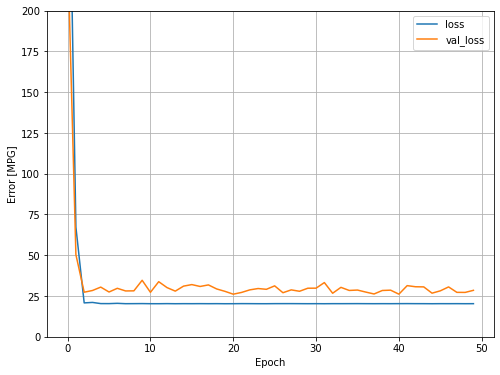

In [154]:
plot_loss(history)

In [155]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [158]:
predicted_stock_price = model.predict(test_dataset)  
predicted_stock_price 

array([[35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.77627 ],
       [35.776264],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],
       [35.776268],


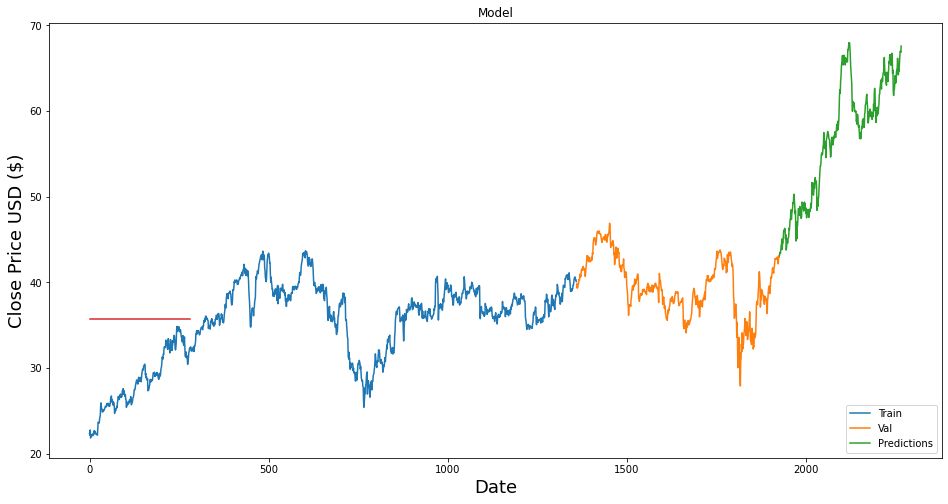

In [160]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data)
plt.plot(val_data)
plt.plot(test_data)
plt.plot(predicted_stock_price)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

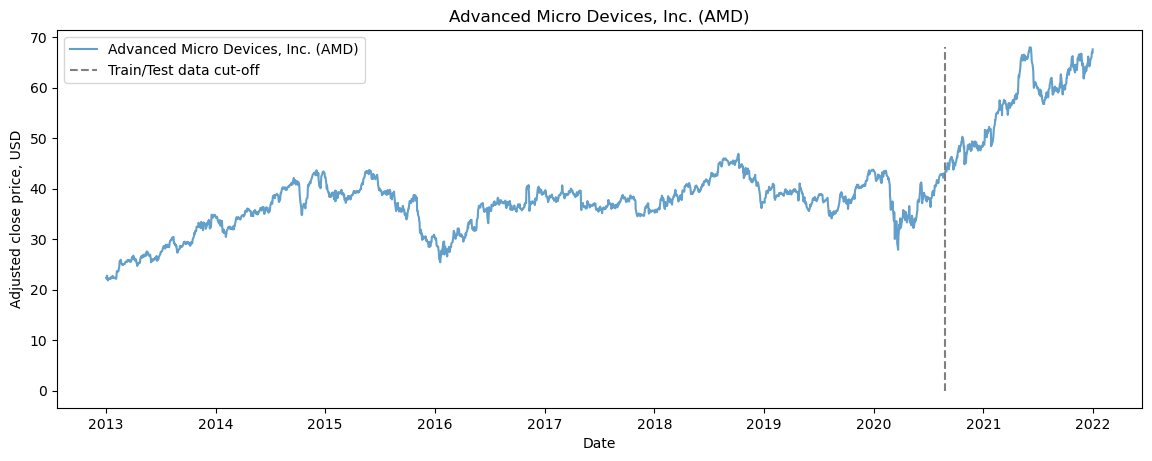

In [161]:

# plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AMD Stock Price')



plt.figure(figsize=(14, 5), dpi=100)
plt.plot(stock_df['Date'], stock_df['Adj Close'], label='Advanced Micro Devices, Inc. (AMD)', alpha = 0.7)

plt.vlines(datetime.date(year,month, day), 0, stock_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
# plt.plot(predicted_stock_price)
plt.legend()
plt.show()